In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib as mpl
from solve_psi import *

In [2]:
def solve_thomas(a, b, c, d):
    """Résout un système tridiagonal."""
    """a xi-1 + b xi + c xi+1 = d"""
    n = len(d)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for i in range(1, n):
        m = ac[i-1]/bc[i-1]
        bc[i] -= m*cc[i-1]
        dc[i] -= m*dc[i-1]
    x = np.zeros(n)
    x[-1] = dc[-1]/bc[-1]
    for i in range(n-2, -1, -1):
        x[i] = (dc[i]-cc[i]*x[i+1])/bc[i]
    return x

In [3]:
def get_velocity(psi, dx, dy, U0):
    u = np.zeros_like(psi)
    v = np.zeros_like(psi)
    # u = d_psi / dy (axe 0)
    u[1:-1, :] = (psi[2:, :] - psi[:-2, :]) / (2*dy)
    # v = -d_psi / dx (axe 1)
    v[:, 1:-1] = -(psi[:, 2:] - psi[:, :-2]) / (2*dx)
    
    u[-1, :] = U0 # Condition limite couvercle
    return u, v

In [4]:
def solve_adi_T(T, u, v, diff_coeff, dt, dx, dy):
    Ny, Nx = T.shape
    T_new = T.copy()
    
    # --- Étape 1 : X-Implicite ---
    T_star = T.copy()
    # CL Dirichlet (Côtés)
    T_star[:, 0] = 1.0
    T_star[:, -1] = 0.0
    
    # Coeffs
    gamma_x = (diff_coeff * dt) / (2 * dx**2)
    gamma_y = (diff_coeff * dt) / (2 * dy**2)
    beta_x = dt / (4 * dx)
    beta_y = dt / (4 * dy)

    for j in range(1, Ny-1):
        a = np.full(Nx-3, -gamma_x - u[j, 1:-2]*beta_x)
        b = np.full(Nx-2, 1 + 2*gamma_x)
        c = np.full(Nx-3, -gamma_x + u[j, 2:-1]*beta_x)
        
        # Partie explicite en Y
        d = T[j, 1:-1] + gamma_y*(T[j+1, 1:-1] - 2*T[j, 1:-1] + T[j-1, 1:-1]) \
            - (v[j, 1:-1]*beta_y)*(T[j+1, 1:-1] - T[j-1, 1:-1])

        d[0] -= a[0]*T_star[j, 0]
        d[-1] -= c[-1]*T_star[j, -1]
        T_star[j, 1:-1] = solve_thomas(a, b, c, d)

    # --- Étape 2 : Y-Implicite ---
    # CL Neumann (Haut/Bas)
    T_star[0, :] = (4*T_star[1, :] - T_star[2, :]) / 3
    T_star[-1, :] = (4*T_star[-2, :] - T_star[-3, :]) / 3
    

    for i in range(1, Nx-1):
        a = np.full(Ny-3, -gamma_y - v[1:-2, i]*beta_y)
        b = np.full(Ny-2, 1 + 2*gamma_y)
        c = np.full(Ny-3, -gamma_y + v[2:-1, i]*beta_y)

        d = T_star[1:-1, i] + gamma_x*(T_star[1:-1, i+1] - 2*T_star[1:-1, i] + T_star[1:-1, i-1]) \
            - (u[1:-1, i]*beta_x)*(T_star[1:-1, i+1] - T_star[1:-1, i-1])

        d[0] -= a[0]*T_new[0, i]
        d[-1] -= c[-1]*T_new[-1, i]
        T_new[1:-1, i] = solve_thomas(a, b, c, d)

    return T_new

In [5]:
def solve_adi_w(w, T, psi, u, v, diff_coeff, source_coeff, dt, dx, dy, U0):
    Ny, Nx = w.shape
    w_new = w.copy()
    s_half = (dt / 2.0) * source_coeff
    gamma_x = (diff_coeff * dt) / (2 * dx**2)
    beta_x = dt / (4 * dx)
    
    # --- Étape 1 : X-Implicite ---
    w_star = w.copy()
    w_star[:, 0] = -2 * psi[:, 1] / dx**2
    w_star[:, -1] = -2 * psi[:, -2] / dx**2
    
    # Coeffs
    gamma_x = (diff_coeff * dt) / (2 * dx**2)
    gamma_y = (diff_coeff * dt) / (2 * dy**2)
    beta_x = dt / (4 * dx)
    beta_y = dt / (4 * dy)


    for j in range(1, Ny-1):
        a = np.full(Nx-3, -gamma_x - u[j, 1:-2]*beta_x)
        b = np.full(Nx-2, 1 + 2*gamma_x)
        c = np.full(Nx-3, -gamma_x + u[j, 2:-1]*beta_x)
        
        d = w[j, 1:-1] + gamma_y*(w[j+1, 1:-1] - 2*w[j, 1:-1] + w[j-1, 1:-1]) \
            - (v[j, 1:-1]*beta_y)*(w[j+1, 1:-1] - w[j-1, 1:-1])

        d += s_half * (T[j, 2:]-T[j, :-2]) / (2*dx)  # dT/dx

        d[0] -= a[0]*w_star[j, 0]
        d[-1] -= c[-1]*w_star[j, -1]
        w_star[j, 1:-1] = solve_thomas(a, b, c, d)

    # --- Étape 2 : Y-Implicite ---
    w_star[0, :] = -2 * psi[1, :] / dy**2
    w_star[-1, :] = -2 * (psi[-2, :] + U0 * dy) / dy**2
    

    for i in range(1, Nx-1):
        a = np.full(Ny-3, -gamma_y - v[1:-2, i]*beta_y)
        b = np.full(Ny-2, 1 + 2*gamma_y)
        c = np.full(Ny-3, -gamma_y + v[2:-1, i]*beta_y)

        d = w_star[1:-1, i] + gamma_x*(w_star[1:-1, i+1] - 2*w_star[1:-1, i] + w_star[1:-1, i-1]) \
            - (u[1:-1, i]*beta_x)*(w_star[1:-1, i+1] - w_star[1:-1, i-1])

        d += s_half * (T[1:-1, i+1] - T[1:-1, i-1]) / (2*dx)  # dT/dx

        d[0] -= a[0]*w_star[0, i]
        d[-1] -= c[-1]*w_star[-1, i]
        w_new[1:-1, i] = solve_thomas(a, b, c, d)

    return w_new

In [6]:
def get_average_nusselt(T, dx):
    """
    Calcule le nombre de Nusselt moyen sur la paroi chaude (gauche, x=0).
    Utilise un schéma décentré d'ordre 2 pour le gradient.
    """
    # Nu local sur chaque point j de la paroi x=0 (colonne 0)
    # T[:, 0] est la paroi (T=1), T[:, 1] et T[:, 2] sont les premiers points intérieurs
    nu_local = -( -3*T[:, 0] + 4*T[:, 1] - T[:, 2] ) / (2 * dx)
    
    return np.mean(nu_local)

In [7]:
nx, ny = 41, 41
Lx, Ly = 1.0, 1.0
dx, dy = Lx/(nx-1), Ly/(ny-1)
dt = 1e-3

U0 = 1.0*10**-3  # Vitesse paroi supérieure

rho = 1 # Air
mu = 1e-5 # Air
#Re = 10000
Pr = 0.71
Ra = 1e4
Re = rho * U0 * (Lx + Ly) / (2 * mu)
Ri = Ra / (Re**2 * Pr)


alpha_sor = 1.74
tol_sor = 1e-6
tol_steady_state = 1e-3
max_iter = 10000

T = np.zeros((nx, ny))
w = np.zeros((nx, ny))
psi = np.zeros((nx, ny))
u, v = get_velocity(psi, dx, dy, U0)
T[:, 0] = 1.0  # Paroi gauche chaude

print("Le nombre de Courant est égale à : " + str(U0*dt/dy))
print("Condition de stabilité de l'algo SOR : " + str(dt/(dy**2)))

print("Re = " + str(Re))


Le nombre de Courant est égale à : 3.9999999999999996e-05
Condition de stabilité de l'algo SOR : 1.5999999999999996
Re = 100.0


In [8]:
assert U0*dt/dy < 1, "Condition de stabilité CFL violée!"
assert dt/(dy**2) < 1/2, "Condition de stabilité SOR violée!"

img_dic = {'T': [T], 'w': [w], 'psi': [psi], 'u': [u], 'v': [v]}

nmax = 2000
n = 0

res_w = []
res_psi = []
res_T = []

n = 0
res_w = []
res_T = []

while n <= max_iter:
    T_new = solve_adi_T(T, u, v, 1/(Re*Pr), dt, dx, dy)
    
    w_new = solve_adi_w(w, T_new, psi, u, v, 1/Re, Ri, dt, dx, dy, U0)
    
    psi_new = solve_poisson_psi(psi, w_new, dx, dy, alpha_sor, tol_sor)
    
    u_new, v_new = get_velocity(psi_new, dx, dy, U0)

    res_w.append(np.max(np.abs(w_new - w)))
    res_T.append(np.max(np.abs(T_new - T)))
    
    if res_w[-1] < tol_steady_state and res_T[-1] < tol_steady_state:
            print(f"\nConvergence atteinte à l'itération {n} !")
            break


    if n % 10 == 0:
        img_dic['T'].append(T.copy())
        img_dic['w'].append(w.copy())
        img_dic['psi'].append(psi.copy())
        u_save, v_save = get_velocity(psi, dx, dy, U0)
        img_dic['u'].append(u_save.copy())
        img_dic['v'].append(v_save.copy())
        print(f"Itération {n}: Résidu w = {res_w[-1]:.2e}, Résidu T = {res_T[-1]:.2e}")
    
    T, w, psi, u, v = T_new, w_new, psi_new, u_new, v_new
    n += 1

AssertionError: Condition de stabilité SOR violée!

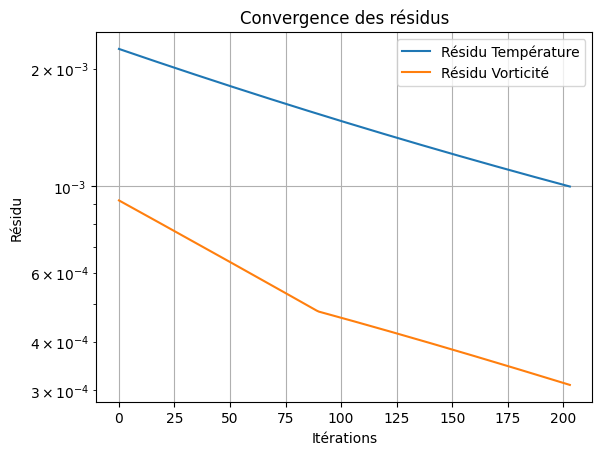

In [ ]:
plt.plot(res_T, label='Résidu Température')
plt.plot(res_w, label='Résidu Vorticité')
plt.yscale('log')
plt.xlabel('Itérations')
plt.ylabel('Résidu')
plt.legend()
plt.title('Convergence des résidus')
plt.grid()
plt.show()

In [ ]:
get_average_nusselt(T, dx)

np.float64(37.897733636412475)

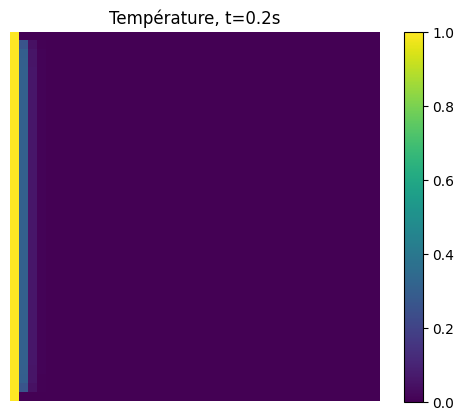

In [ ]:
def animer_matrices(liste_matrices, fps=20, save_path=None, Name=''):
    fig, ax = plt.subplots()
    
    # Initialisation de l'affichage avec la première matrice
    # cmap='viridis' est souvent mieux pour les données scientifiques que 'gray'
    im = ax.imshow(liste_matrices[0], animated=True, cmap='viridis', origin='lower', vmin = np.min(liste_matrices), vmax = np.max(liste_matrices))
    plt.colorbar(im) # Optionnel : affiche l'échelle des valeurs
    plt.title('Animation des Matrices')
    ax.axis('off')
    

    # Fonction de mise à jour appelée pour chaque frame
    def update(i):
        im.set_array(liste_matrices[i])
        ax.set_title(f"{Name}, t={i*dt*10:.1f}s")
        return [im]

    # Création de l'animation
    # interval = délai entre images en millisecondes (1000 / fps)
    ani = animation.FuncAnimation(fig, update, frames=len(liste_matrices), 
                        interval=1000/fps, blit=True)

    # SAUVEGARDE (Optionnel)
    if save_path:
        if save_path.endswith('.gif'):
            ani.save(save_path, writer='pillow', fps=fps)
        else:
            # Nécessite l'installation de 'ffmpeg' sur votre ordinateur
            ani.save(save_path, writer='ffmpeg', fps=fps)
    
    plt.show()
    return ani

animer_matrices(img_dic['T'], fps=24, save_path='mon_animation.gif', Name = 'Température')

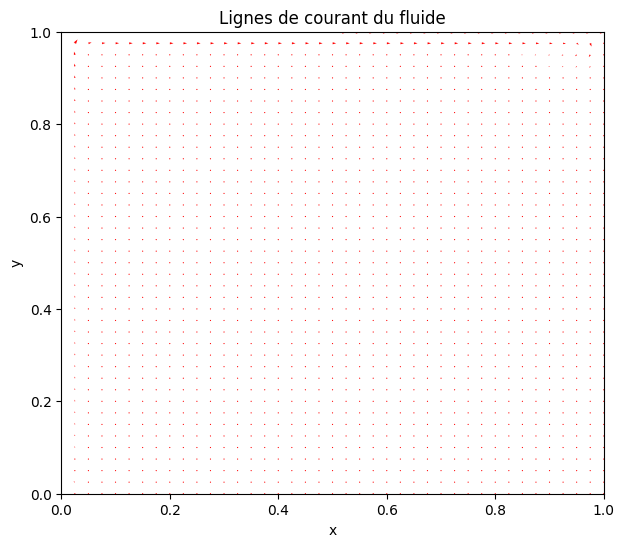

In [ ]:
# 1. Préparation de la grille
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# Sélection d'une itération (ex: la dernière enregistrée)
k = 3
u_plot = img_dic['u'][k]
v_plot = img_dic['v'][k]

plt.figure(figsize=(7, 6))
# streamplot calcule automatiquement les lignes tangentes au vecteur (u, v)
plt.quiver(X, Y, u_plot, v_plot, color='red', linewidth=1)
plt.title("Lignes de courant du fluide")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, Lx)
plt.ylim(0, Ly)
plt.show()

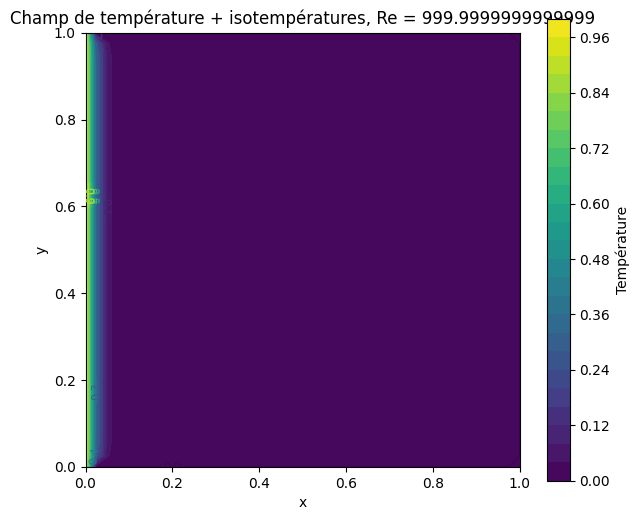

In [ ]:
# 1. Préparation de la grille
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# Sélection d'une itération (ex: la dernière enregistrée)
k = -1
T_plot = img_dic['T'][k]  # <-- adapte la clé si besoin ("T", "temp", etc.)

plt.figure(figsize=(7, 6))
levels = 30

cf = plt.contourf(X, Y, T_plot, levels=levels)   # champ coloré
cs = plt.contour(X, Y, T_plot, levels=10, linewidths=0.8)  # isothermes
plt.clabel(cs, inline=True, fontsize=8)

plt.colorbar(cf, label="Température")
plt.title("Champ de température + isotempératures, Re = " + str(Re))
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, Lx)
plt.ylim(0, Ly)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()